
--- Escenario 1 ---


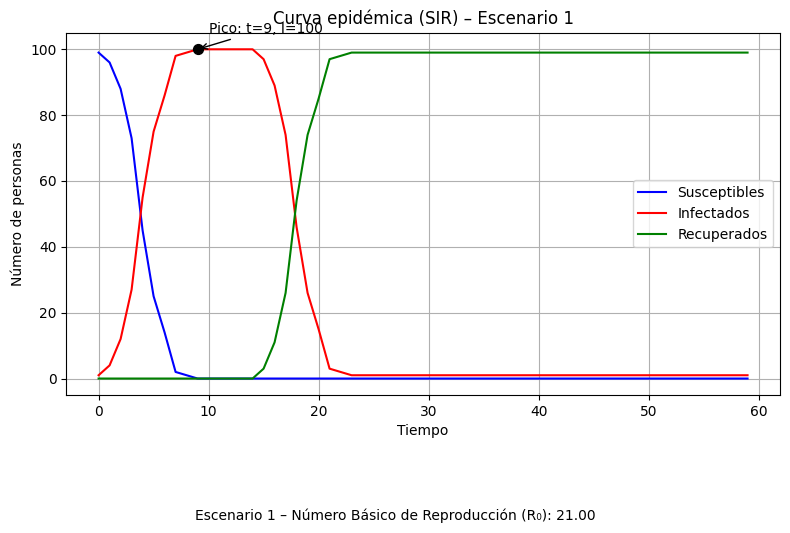


--- Escenario 2 ---


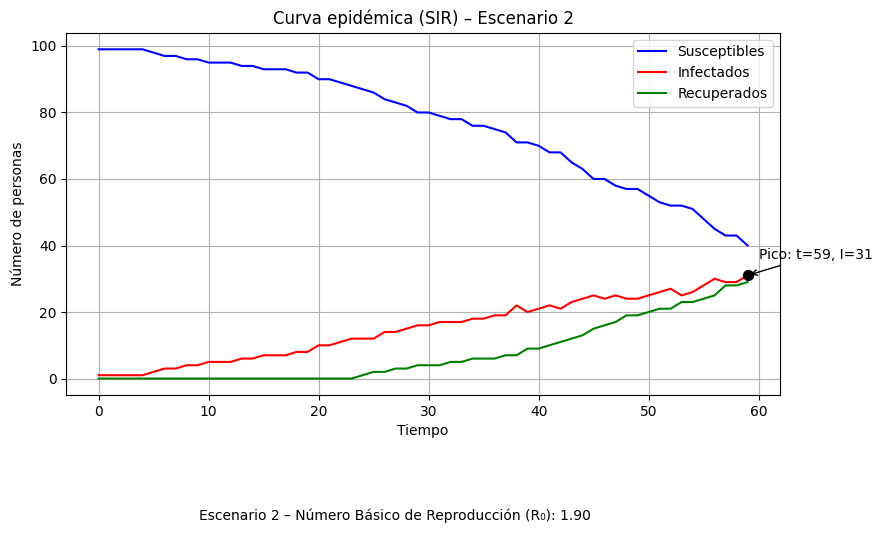


--- Escenario 3 ---


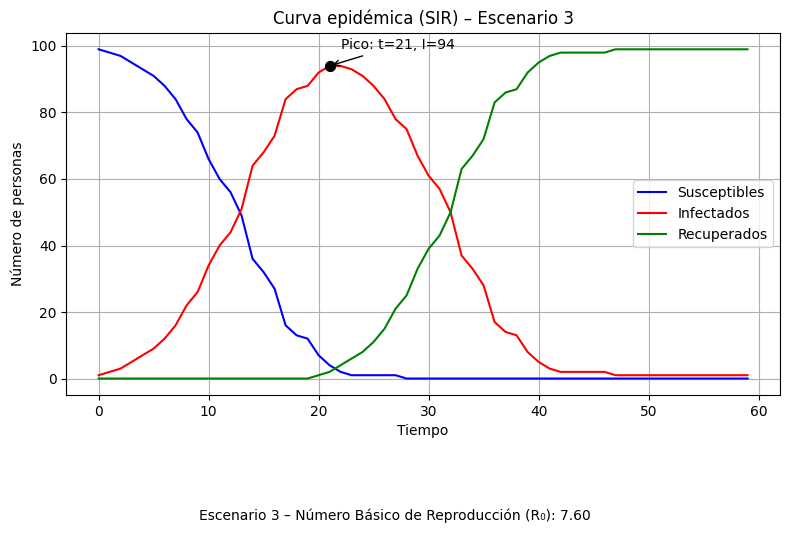

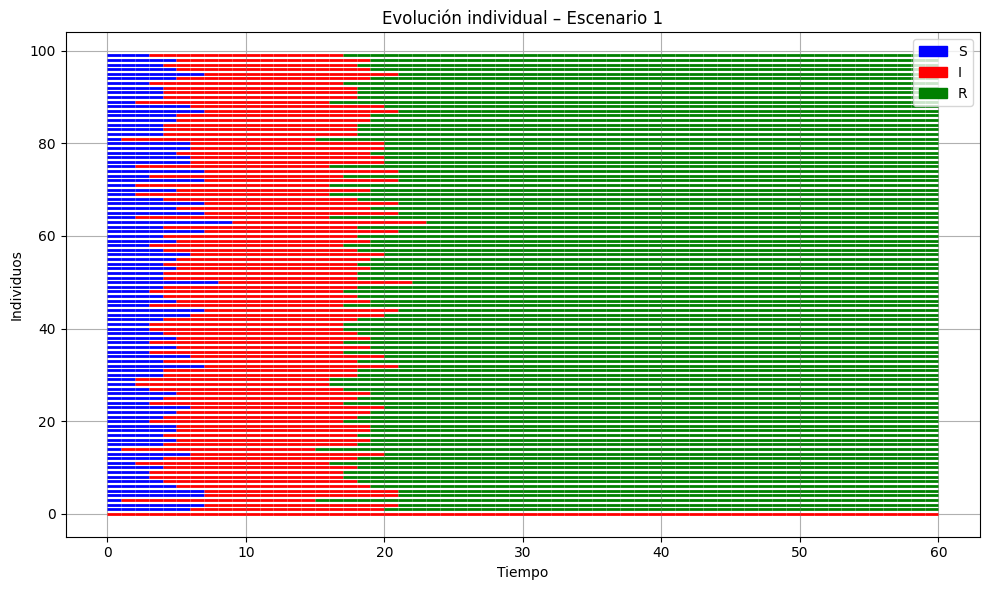

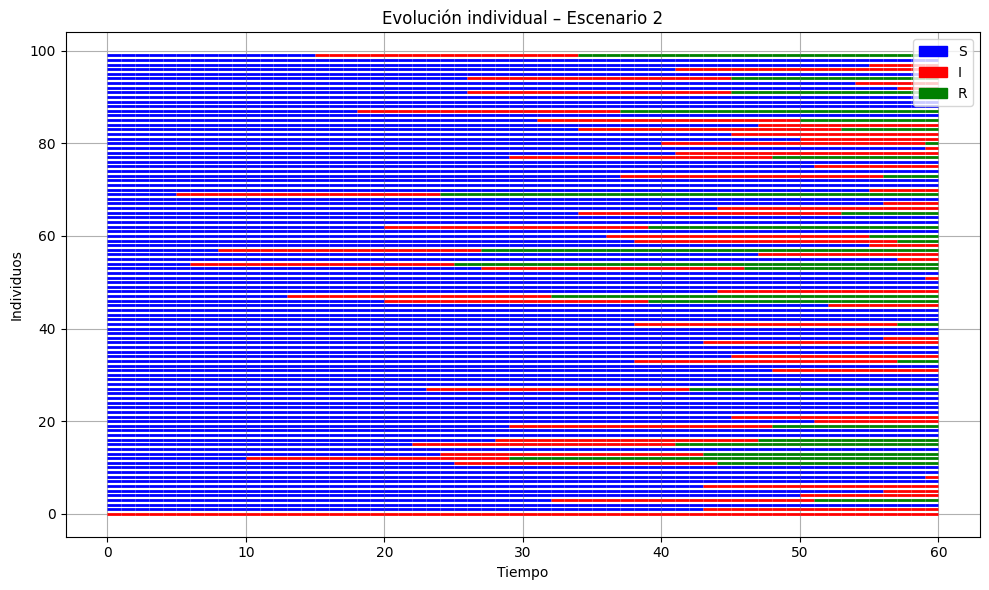

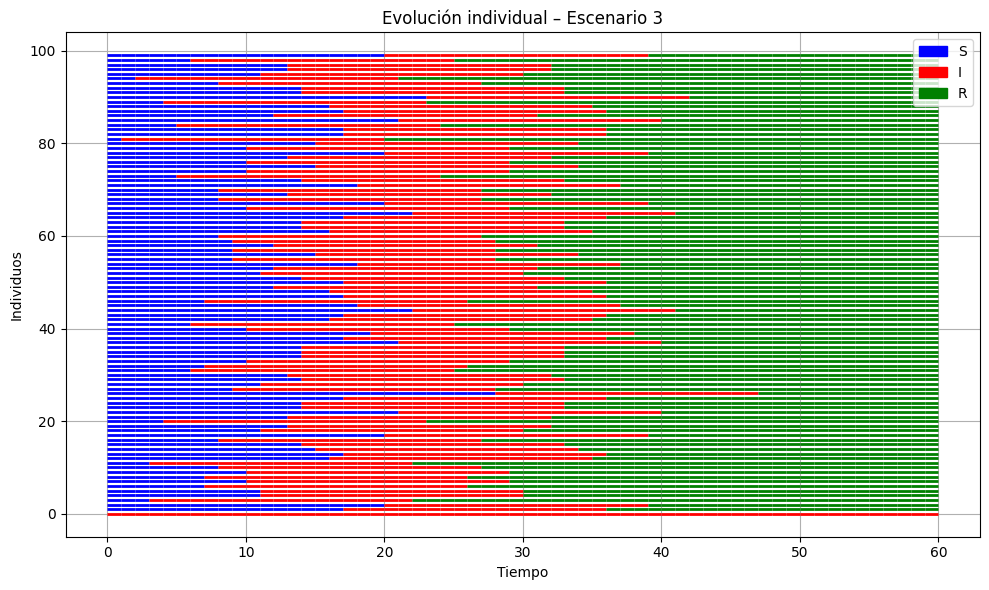

In [1]:
import simpy
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

class Persona:
    def __init__(self, id, infect_prob, rec_time):
        self.id = id
        self.estado = "S"
        self.infect_prob = infect_prob
        self.rec_time = rec_time
        self.en_proceso = False
        self.historial = []

    def infectar(self, env):
        if self.estado == "S" and not self.en_proceso:
            self.en_proceso = True
            if random.random() < self.infect_prob:
                self.estado = "I"
                yield env.timeout(self.rec_time)
                self.estado = "R"
            self.en_proceso = False

def run_scenario(nombre, infect, infect_prob, rec_time,
                 num_personas=50, duracion=30, semilla=42):
    random.seed(semilla)
    env = simpy.Environment()
    # Crear personas
    personas = [Persona(i, infect_prob, rec_time) for i in range(num_personas)]
    personas[0].estado = "I"  # Paciente cero

    tiempos, S, I, R = [], [], [], []

    # Loop principal, un día a la vez
    while env.now < duracion:
        # Registrar estado actual en el historial
        for p in personas:
            p.historial.append((env.now, p.estado))

        # Para cada infectado, disparar procesos de infección
        for p in personas:
            if p.estado == "I":
                vecinos = random.sample(personas, infect)
                for v in vecinos:
                    env.process(v.infectar(env))

        # Contar S, I, R
        s = sum(p.estado == "S" for p in personas)
        i = sum(p.estado == "I" for p in personas)
        r = sum(p.estado == "R" for p in personas)
        tiempos.append(env.now);  S.append(s);  I.append(i);  R.append(r)

        # Avanzar el tiempo un día
        env.run(until=env.now + 1)

    # ========= Gráfica SIR =========
    plt.figure(figsize=(8,5))
    plt.plot(tiempos, S, label="Susceptibles", color="blue")
    plt.plot(tiempos, I, label="Infectados",  color="red")
    plt.plot(tiempos, R, label="Recuperados", color="green")
    plt.xlabel("Tiempo")
    plt.ylabel("Número de personas")
    plt.title(f"Curva epidémica (SIR) – {nombre}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Pico de infección
    pico_idx    = max(range(len(I)), key=lambda idx: I[idx])
    tiempo_pico = tiempos[pico_idx]
    valor_pico  = I[pico_idx]
    plt.scatter([tiempo_pico], [valor_pico], color="black", s=50, zorder=5)
    plt.annotate(
        f"Pico: t={tiempo_pico}, I={valor_pico}",
        xy=(tiempo_pico, valor_pico),
        xytext=(tiempo_pico+1, valor_pico+5),
        arrowprops=dict(arrowstyle="->", color="black")
    )

    # Mostrar R₀ (Numero basico de reproduccion) debajo
    r0 = infect * infect_prob * rec_time
    plt.figtext(0.5, -0.05,
                f"{nombre} – Número Básico de Reproducción (R₀): {r0:.2f}",
                wrap=True, ha='center', fontsize=10)
    plt.subplots_adjust(bottom=0.2)
    plt.show()

    return personas, duracion

# ======== Escenarios ========
escenarios = [
    {"nombre":"Escenario 1", "infect":5, "infect_prob":0.3, "rec_time":14},
    {"nombre":"Escenario 2", "infect":1, "infect_prob":0.1, "rec_time":19},
    {"nombre":"Escenario 3", "infect":2, "infect_prob":0.2, "rec_time":19},
]

# Ejecutar cada escenario por separado
resultados = []
for sc in escenarios:
    print(f"\n--- {sc['nombre']} ---")
    personas, dur = run_scenario(
        sc["nombre"],
        sc["infect"],
        sc["infect_prob"],
        sc["rec_time"],
        num_personas=100,
        duracion=60
    )
    resultados.append((sc["nombre"], personas, dur))

# ======== Gráfico de estados individuales ========
estado_color = {"S":"blue", "I":"red", "R":"green"}

for nombre, personas, dur in resultados:
    plt.figure(figsize=(10,6))
    for idx, p in enumerate(personas):
        # Dibujar segmentos según historial
        for (t0, e0), (t1, _) in zip(p.historial, p.historial[1:]):
            plt.hlines(idx, t0, t1, colors=estado_color[e0], linewidth=2)
        # Tramo final hasta el final de la simulación
        if p.historial:
            t_last, e_last = p.historial[-1]
            plt.hlines(idx, t_last, dur, colors=estado_color[e_last], linewidth=2)

    plt.xlabel("Tiempo")
    plt.ylabel("Individuos")
    plt.title(f"Evolución individual – {nombre}")
    # Leyenda
    patches = [mpatches.Patch(color=c, label=s) for s,c in estado_color.items()]
    plt.legend(handles=patches, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

